# k-nearest Neighbors

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline

from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.neighbors import (KNeighborsClassifier, 
                               KNeighborsRegressor)
from sklearn.model_selection import (cross_val_score, 
                                     cross_val_predict, 
                                     GridSearchCV)
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler, scale
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from yellowbrick.model_selection import ValidationCurve, LearningCurve

In [4]:
sns.set_style('whitegrid')

# Get the Data
From Kaggle API

In [5]:
house_sales = pd.read_csv('kc_house_data.csv')
house_sales = house_sales.drop(
    ['id', 'zipcode', 'lat', 'long', 'date'], axis=1)
house_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21613 non-null  float64
 1   bedrooms       21613 non-null  int64  
 2   bathrooms      21613 non-null  float64
 3   sqft_living    21613 non-null  int64  
 4   sqft_lot       21613 non-null  int64  
 5   floors         21613 non-null  float64
 6   waterfront     21613 non-null  int64  
 7   view           21613 non-null  int64  
 8   condition      21613 non-null  int64  
 9   grade          21613 non-null  int64  
 10  sqft_above     21613 non-null  int64  
 11  sqft_basement  21613 non-null  int64  
 12  yr_built       21613 non-null  int64  
 13  yr_renovated   21613 non-null  int64  
 14  sqft_living15  21613 non-null  int64  
 15  sqft_lot15     21613 non-null  int64  
dtypes: float64(3), int64(13)
memory usage: 2.6 MB


# Select & Transform Features
#### Asset Prices often have long tails

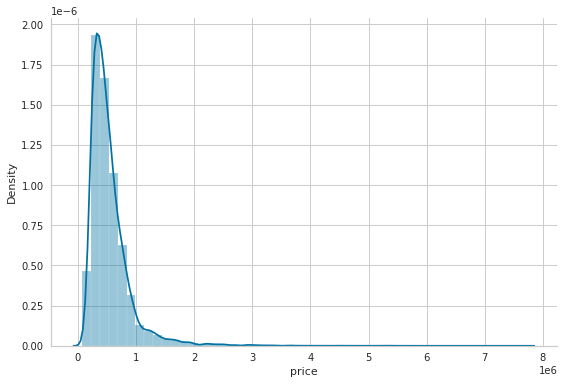

In [6]:
sns.distplot(house_sales.price)
sns.despine()
plt.tight_layout();

# Use log-transform
Useful for dealing with skewed data.



In [7]:
X_all = house_sales.drop('price', axis=1)
y = np.log(house_sales.price)

# Mutual information regression

In [8]:
mi_reg = pd.Series(mutual_info_regression(X_all, y),
                   index=X_all.columns).sort_values(ascending=False)
mi_reg

sqft_living      0.346977
grade            0.343069
sqft_living15    0.270051
sqft_above       0.261016
bathrooms        0.203311
sqft_lot15       0.084725
bedrooms         0.077364
floors           0.074616
yr_built         0.073974
sqft_basement    0.069708
sqft_lot         0.060760
view             0.059437
waterfront       0.010084
yr_renovated     0.010048
condition        0.006000
dtype: float64

In [9]:
X = X_all.loc[:, mi_reg.iloc[:10].index]

# Bivariate Scatter Plots

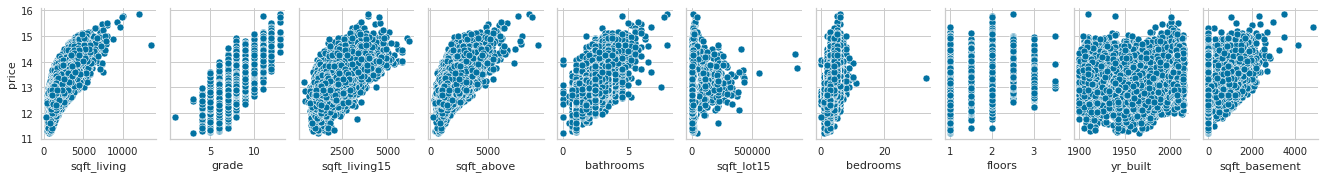

In [10]:
g = sns.pairplot(X.assign(price=y), y_vars=['price'], x_vars=X.columns, aspect=30/40)
sns.despine();

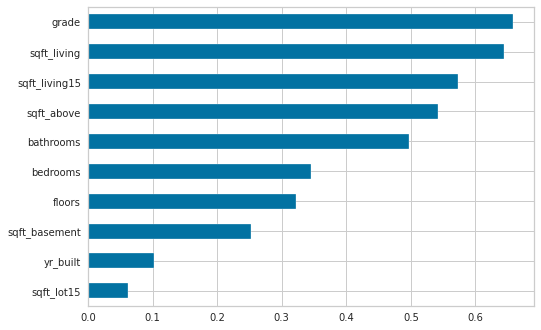

In [11]:
correl = X.apply(lambda x: spearmanr(x, y)[0])
correl.sort_values().plot.barh();

# KNN Regression

In [12]:
X_scaled = scale(X)

In [13]:
model = KNeighborsRegressor()
model.fit(X=X_scaled, y=y)

KNeighborsRegressor()

In [14]:
y_pred = model.predict(X_scaled)

# Regression Error Metrics 
Computing the prediction error

In [15]:
from sklearn.metrics import (mean_squared_error,
                             mean_absolute_error,
                             mean_squared_log_error,
                             median_absolute_error,
                             explained_variance_score,
                             r2_score)

In [16]:
error = (y - y_pred).rename('prediction errors')

In [17]:
scores = dict(
    rmse = np.sqrt(mean_squared_error(y_true=y, y_pred=y_pred)),
    rmsle = np.sqrt(mean_squared_log_error(y_true=y, y_pred=y_pred)),
    mean_ae = mean_absolute_error(y_true=y, y_pred=y_pred),
    median_ae = median_absolute_error(y_true=y, y_pred=y_pred),
    r2score = explained_variance_score(y_true=y, y_pred=y_pred),
)

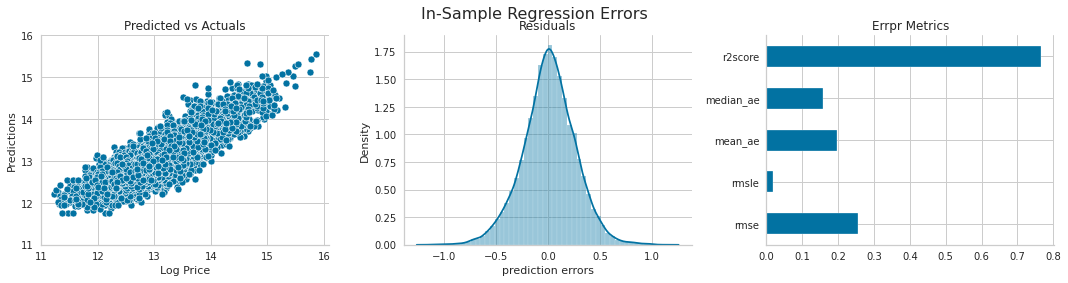

In [18]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 4))
sns.scatterplot(x=y, y=y_pred, ax=axes[0])
axes[0].set_xlabel("Log Price")
axes[0].set_ylabel("Predictions")
axes[0].set_ylim(11, 16)
axes[0].set_title("Predicted vs Actuals")
sns.distplot(error, ax=axes[1])
axes[1].set_title("Residuals")
pd.Series(scores).plot.barh(ax=axes[2], title="Errpr Metrics")
fig.suptitle('In-Sample Regression Errors', fontsize=16)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.88)

# Cross-Validation

In [19]:
def rmse(y_true, pred):
    return np.sqrt(mean_squared_error(y_true=y_true, y_pred=pred))

rmse_score = make_scorer(rmse)

In [20]:
cv_rmse = {}
n_neighors = [1] + list(range(5, 51, 5))
for n in n_neighors:
    pipe = Pipeline([('Scaler', StandardScaler()),
                     ('knn', KNeighborsRegressor(n_neighbors=n))])
    cv_rmse[n] = cross_val_score(pipe,
                                 X=X,
                                 y=y,
                                 scoring=rmse_score,
                                 cv=5)

In [21]:
cv_rmse = pd.DataFrame.from_dict(cv_rmse, orient='index')
best_n, best_rmse = cv_rmse.mean(1).idxmin(), cv_rmse.mean(1).min()
cv_rmse = cv_rmse.stack().reset_index()
cv_rmse.columns = ['n', 'fold', 'RMSE']


Text(0.5, 1.0, 'Cross-Validation Results KNN | Best N:  30 | Best RMSE:  0.30')

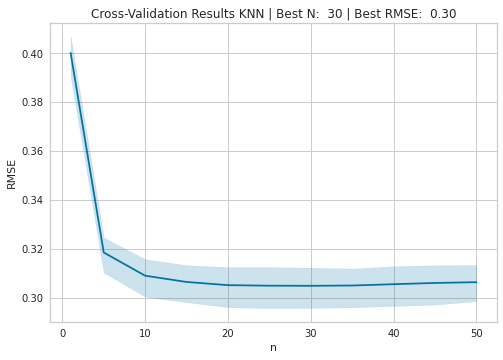

In [22]:
ax = sns.lineplot(x='n', y='RMSE', data=cv_rmse)
ax.set_title(f'Cross-Validation Results KNN | Best N: {best_n: d} | Best RMSE: {best_rmse: .2f}')

# Actuals vs Predicted

<AxesSubplot:xlabel='price'>

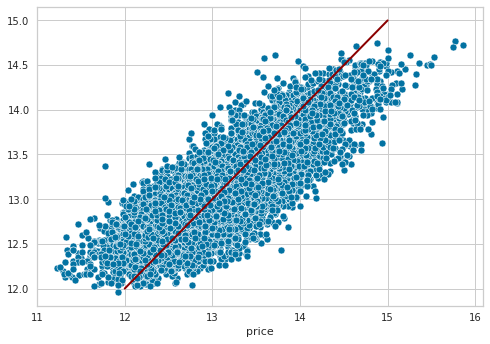

In [23]:
pipe = Pipeline([('Scaler', StandardScaler()),
                 ('knn', KNeighborsRegressor(n_neighbors=best_n))])
y_pred = cross_val_predict(pipe, X, y, cv=5)

ax = sns.scatterplot(x=y, y=y_pred)
y_range = list(range(int(y.min() + 1), int(y.max() + 1)))
pd.Series(y_range, index=y_range).plot(ax=ax, lw=2, c='darkred')

### Cross-Validation Errors

In [24]:
error = (y - y_pred).rename('Prediction Errors')

In [25]:
scores = dict(
    rmse=np.sqrt(mean_squared_error(y_true=y, y_pred=y_pred)),
    rmsle=np.sqrt(mean_squared_log_error(y_true=y, y_pred=y_pred)),
    mean_ae=mean_absolute_error(y_true=y, y_pred=y_pred),
    median_ae=median_absolute_error(y_true=y, y_pred=y_pred),
    r2score=explained_variance_score(y_true=y, y_pred=y_pred)
)

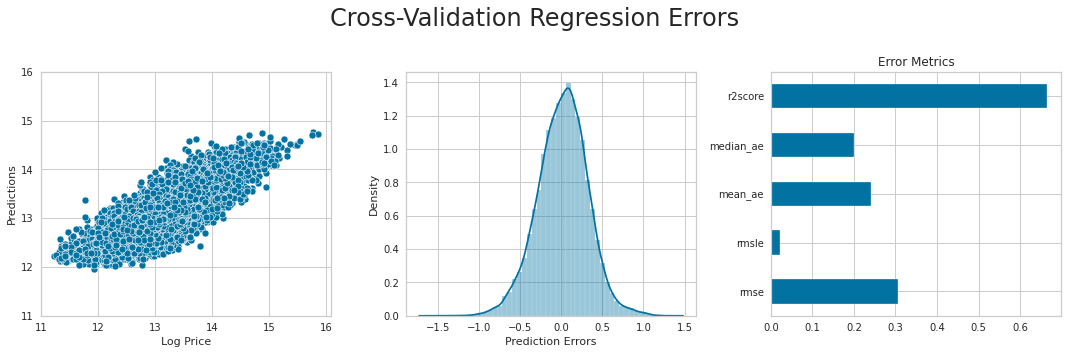

In [26]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
sns.scatterplot(x=y, y=y_pred, ax=axes[0])
axes[0].set_xlabel('Log Price')
axes[0].set_ylabel('Predictions')
axes[0].set_ylim(11, 16)
sns.distplot(error, ax=axes[1])
pd.Series(scores).plot.barh(ax=axes[2], title='Error Metrics')
fig.suptitle('Cross-Validation Regression Errors', fontsize=24)
fig.tight_layout()
plt.subplots_adjust(top=.8);

# GridSearch CV with Pipeline

In [27]:
pipe = Pipeline([('scaler', StandardScaler()), 
                 ('knn', KNeighborsRegressor())])

n_folds = 5
n_neighbors = tuple(range(5, 101, 5))

param_grid = {'knn__n_neighbors': n_neighbors}

estimator = GridSearchCV(estimator=pipe,
                         param_grid=param_grid,
                         cv=n_folds,
                         scoring=rmse_score)

estimator.fit(X=X, y=y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsRegressor())]),
             param_grid={'knn__n_neighbors': (5, 10, 15, 20, 25, 30, 35, 40, 45,
                                              50, 55, 60, 65, 70, 75, 80, 85,
                                              90, 95, 100)},
             scoring=make_scorer(rmse))

In [28]:
cv_results = estimator.cv_results_

In [29]:
test_scores = pd.DataFrame({fold: cv_results[f'split{fold}_test_score'] for fold in range(n_folds)},
                           index=n_neighbors).stack().reset_index()
test_scores.columns = ['k', 'fold', 'RMSE']

In [30]:
mean_rmse = test_scores.groupby('k').RMSE.mean()
best_k, best_score = mean_rmse.idxmin(), mean_rmse.min()

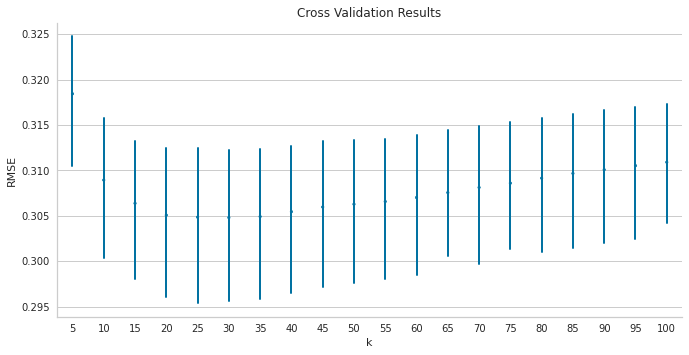

In [31]:
sns.pointplot(x='k', y='RMSE', data=test_scores, scale=.3, join=False, errwidth=2)
plt.title('Cross Validation Results')
sns.despine()
plt.tight_layout()
plt.gcf().set_size_inches(10, 5);

### Train & Validation Curves mit yellowbricks

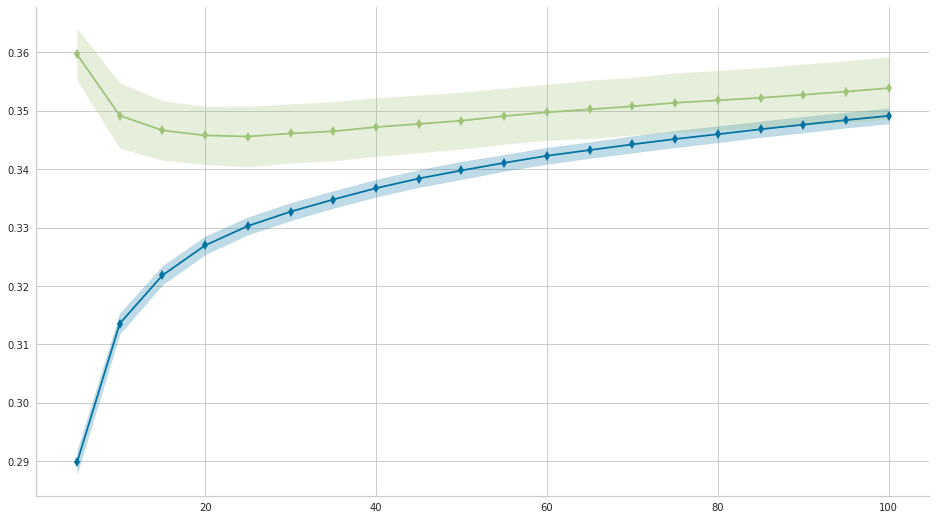

In [32]:
fig, ax = plt.subplots(figsize=(16, 9))
val_curve = ValidationCurve(KNeighborsRegressor(),
                           param_name='n_neighbors',
                           param_range=n_neighbors,
                           cv=5,
                           scoring=rmse_score,
                           ax=ax)
val_curve.fit(X, y)

sns.despine()
fig.tight_layout;

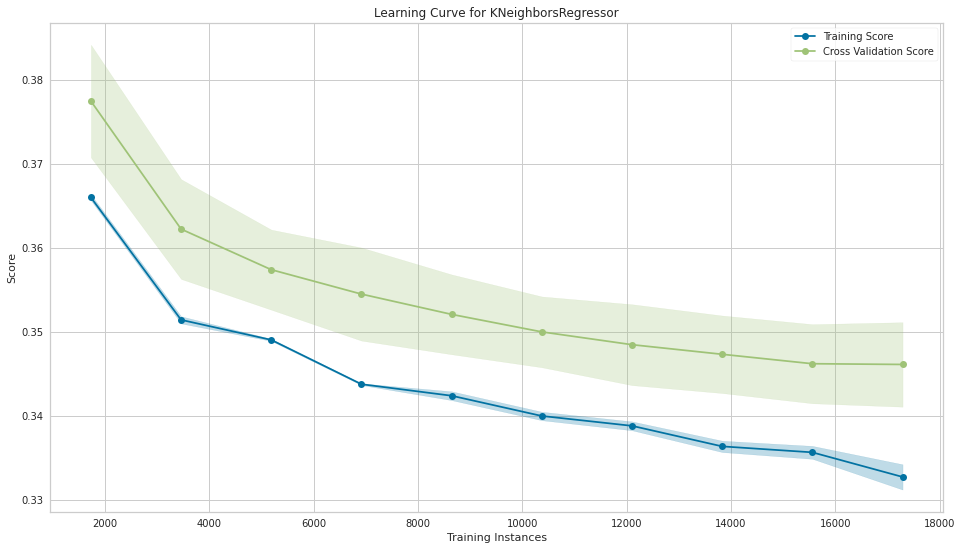

<Figure size 576x396 with 0 Axes>

In [33]:
fig, ax = plt.subplots(figsize=(16, 9))
l_curve = LearningCurve(KNeighborsRegressor(n_neighbors=best_k), 
                        train_sizes=np.arange(.1, 1.01, .1),
                        scoring=rmse_score, 
                        cv=5, 
#                         n_jobs=-1,
                        ax=ax)
l_curve.fit(X, y)
l_curve.poof()
sns.despine()
fig.tight_layout();

# Binary Classification

In [34]:
y_binary = (y>y.median()).astype(int)

In [35]:
n_neighbors = tuple(range(5, 151, 10))
n_folds = 5
scoring = 'roc_auc'

In [36]:
pipe = Pipeline([('scaler', StandardScaler()), 
                 ('knn', KNeighborsClassifier())])

param_grid = {'knn__n_neighbors': n_neighbors}

estimator = GridSearchCV(estimator=pipe,
                         param_grid=param_grid,
                         cv=n_folds,
                         scoring=scoring,
#                          n_jobs=-1
                        )
estimator.fit(X=X, y=y_binary)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': (5, 15, 25, 35, 45, 55, 65, 75, 85,
                                              95, 105, 115, 125, 135, 145)},
             scoring='roc_auc')

In [37]:
best_k = estimator.best_params_['knn__n_neighbors']

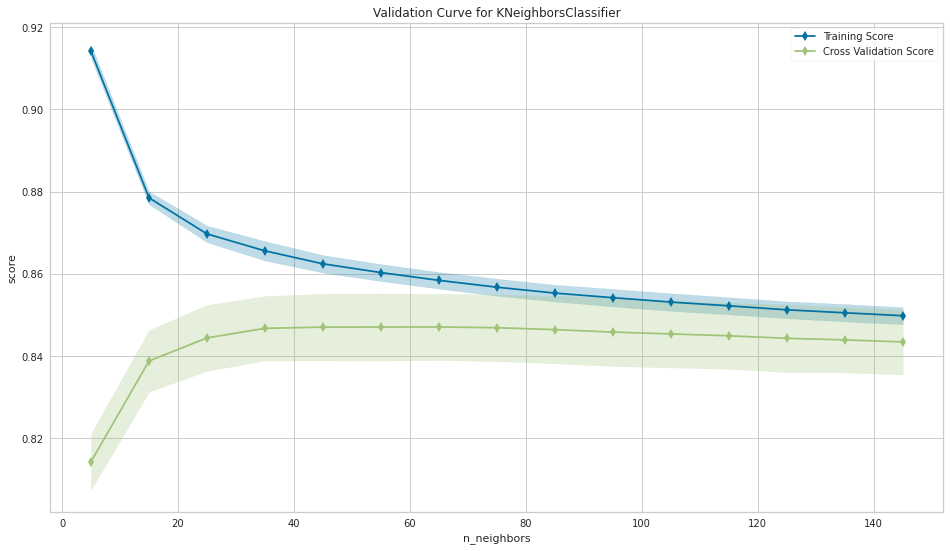

<Figure size 576x396 with 0 Axes>

In [38]:
fig, ax = plt.subplots(figsize=(16, 9))
val_curve = ValidationCurve(KNeighborsClassifier(),
                      param_name='n_neighbors',
                      param_range=n_neighbors,
                      cv=n_folds,
                      scoring=scoring,
#                       n_jobs=-1,
                      ax=ax)
val_curve.fit(X, y_binary)
val_curve.poof()
sns.despine()
fig.tight_layout();

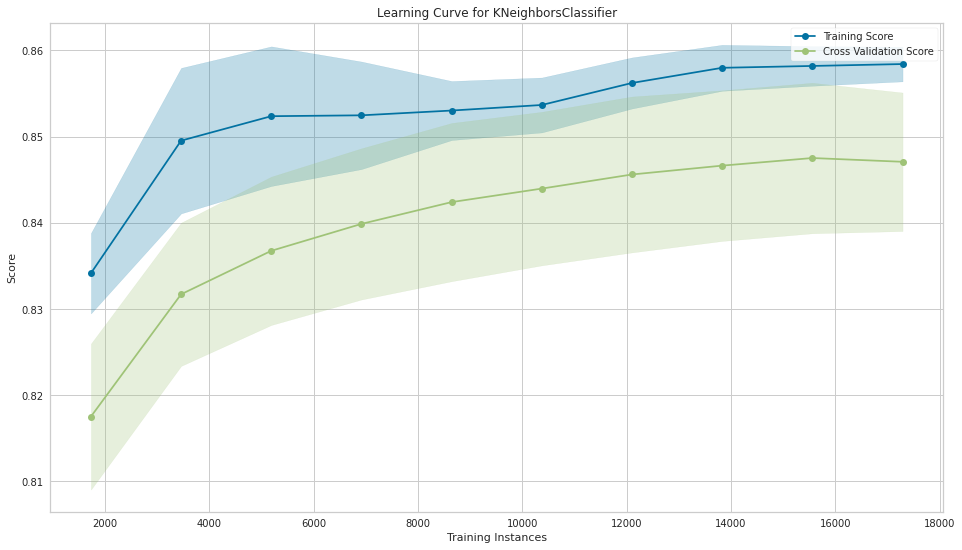

<Figure size 576x396 with 0 Axes>

In [39]:
fig, ax = plt.subplots(figsize=(16, 9))
l_curve = LearningCurve(KNeighborsClassifier(n_neighbors=best_k), 
                        train_sizes=np.arange(.1, 1.01, .1),
                        scoring=scoring, 
                        cv=5, 
#                         n_jobs=-1,
                        ax=ax)
l_curve.fit(X, y_binary)
l_curve.poof()
sns.despine()
fig.tight_layout();

# Classification Metrics

In [40]:
from sklearn.metrics import (classification_report,
                             accuracy_score,
                             zero_one_loss,
                             roc_auc_score,
                             roc_curve,
                             brier_score_loss,
                             cohen_kappa_score,
                             confusion_matrix,
                             fbeta_score,
                             hamming_loss,
                             hinge_loss,
                             jaccard_score,
                             log_loss,
                             matthews_corrcoef,
                             f1_score,
                             average_precision_score,
                             precision_recall_curve)

In [41]:
y_score = cross_val_predict(KNeighborsClassifier(best_k), 
                           X=X, 
                           y=y_binary, 
                           cv=5, 
                           n_jobs=-1, 
                           method='predict_proba')[:, 1]

### Using Predicted Probabilities

In [42]:
pred_scores = dict(y_true=y_binary,y_score=y_score)

### ROC AUC

In [43]:
roc_auc_score(**pred_scores)

0.8460220757597617

In [44]:
cols = ['False Positive Rate', 'True Positive Rate', 'threshold']
roc = pd.DataFrame(dict(zip(cols, roc_curve(**pred_scores))))

### Precision-Recall

In [49]:
precision, recall, ts = precision_recall_curve(y_true=y_binary, probas_pred=y_score)
pr_curve = pd.DataFrame({'Precision': precision, 'Recall': recall})

### F1 Score - Optimize Threshold

In [53]:
f1 = pd.Series({t: f1_score(y_true=y_binary, y_pred=y_score>t) for t in ts})
best_threshold = f1.idxmax()

### Plot

In [54]:
roc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67 entries, 0 to 66
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   False Positive Rate  67 non-null     float64
 1   True Positive Rate   67 non-null     float64
 2   threshold            67 non-null     float64
dtypes: float64(3)
memory usage: 1.7 KB


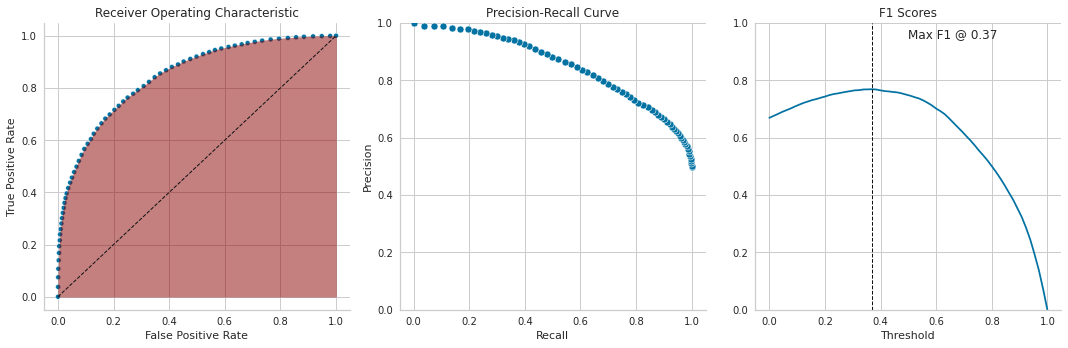

In [55]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))

ax = sns.scatterplot(x='False Positive Rate', y='True Positive Rate', data=roc, size=5, legend=False, ax=axes[0])
axes[0].plot(np.linspace(0,1,100), np.linspace(0,1,100), color='k', ls='--', lw=1)
axes[0].fill_between(y1=roc['True Positive Rate'], x=roc['False Positive Rate'], alpha=.5,color='darkred')
axes[0].set_title('Receiver Operating Characteristic')


sns.scatterplot(x='Recall', y='Precision', data=pr_curve, ax=axes[1])
axes[1].set_ylim(0,1)
axes[1].set_title('Precision-Recall Curve')


f1.plot(ax=axes[2], title='F1 Scores', ylim=(0,1))
axes[2].set_xlabel('Threshold')
axes[2].axvline(best_threshold, lw=1, ls='--', color='k')
axes[2].text(s=f'Max F1 @ {best_threshold:.2f}', x=.5, y=.95)
sns.despine()
fig.tight_layout();

### Average Precision

In [56]:
average_precision_score(y_true=y_binary, y_score=y_score)

0.8484151933803561

### Brier Score

In [57]:
brier_score_loss(y_true=y_binary, y_prob=y_score)

0.16022877968743884

### Use Predictions after thresholding

In [58]:
y_pred = y_score > best_threshold

In [60]:
scores = dict(y_true=y_binary, y_pred=y_pred)

### F-beta Score

In [61]:
fbeta_score(**scores, beta=1)

0.7683696060821253

In [62]:
print(classification_report(**scores))

              precision    recall  f1-score   support

           0       0.82      0.63      0.71     10864
           1       0.70      0.86      0.77     10749

    accuracy                           0.74     21613
   macro avg       0.76      0.74      0.74     21613
weighted avg       0.76      0.74      0.74     21613



### Confusion Matrix

In [63]:
confusion_matrix(**scores)

array([[6871, 3993],
       [1552, 9197]])

### Accuracy

In [64]:
accuracy_score(**scores)

0.7434414472771017

### Zero-One Loss

In [65]:
zero_one_loss(**scores)

0.2565585527228983

### Hamming Loss
Fraction of labels that are incorrectly predicted

In [66]:
hamming_loss(**scores)

0.25655855272289824

### Cohen's Kappa
Score that expresses the level of agreement between two annotators on a classification problem.

In [67]:
cohen_kappa_score(y1=y_binary, y2=y_pred)

0.4874843729009637

### Hinge Loss

In [68]:
hinge_loss(y_true=y_binary, pred_decision=y_pred)

0.759218988571693

### Jaccard Similarity

In [69]:
jaccard_score(**scores)

0.6238637905304572

### Log Loss / Cross Entropy Loss

In [70]:
log_loss(**scores)

8.861366210258572

### Matthews Correlation Coefficient

In [71]:
matthews_corrcoef(**scores)

0.500386387346984

### Multi-Class

In [72]:
y_multi = pd.qcut(y, q=3, labels=[0,1,2])

In [73]:
n_neighbors = tuple(range(5, 151, 10))
n_folds = 5
scoring = 'accuracy'

In [74]:
pipe = Pipeline([('scaler', StandardScaler()), 
                 ('knn', KNeighborsClassifier())])

param_grid = {'knn__n_neighbors': n_neighbors}

estimator = GridSearchCV(estimator=pipe,
                         param_grid=param_grid,
                         cv=n_folds,
                         n_jobs=-1
                        )
estimator.fit(X=X, y=y_multi)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__n_neighbors': (5, 15, 25, 35, 45, 55, 65, 75, 85,
                                              95, 105, 115, 125, 135, 145)})

In [75]:
y_pred = cross_val_predict(estimator.best_estimator_, 
                           X=X, 
                           y=y_multi, 
                           cv=5, 
                           n_jobs=-1, 
                           method='predict')

In [76]:
print(classification_report(y_true=y_multi, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.67      0.71      0.69      7226
           1       0.52      0.52      0.52      7223
           2       0.77      0.74      0.75      7164

    accuracy                           0.65     21613
   macro avg       0.65      0.65      0.65     21613
weighted avg       0.65      0.65      0.65     21613

